# Raport - "SIM_TEST_TRAIN"

Dane zawierają 2 foldery:
- dicom-images-train
- dicom-images-test 

W każdym folderze są pliku formatu DICOM (Digital Imaging and Communications in Medicine). 

Dodatkowo mamy ramke:
- train-rle.csv 

Ramka ta zawiera kodowanie maski dla zdjęć z folderów.

In [3]:
import numpy as np 
import pandas as pd 
import pydicom,os,cv2
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

#### Jaka jest liczba zdjęć w folderze "dicom-images-train", a jaka w folderze "dicom-images-test"?

In [4]:
train_fns = sorted(glob('C:/Users/maaja/Desktop/AndrzejczukMaja/archive/siim/dicom-images-train/*/*/*.dcm'))
test_fns = sorted(glob('C:/Users/maaja/Desktop/AndrzejczukMaja/archive/siim/dicom-images-test/*/*/*.dcm'))

In [3]:
print(f'Liczba zdjęć w folderze dicom-images-train jest równa {len(train_fns)}')
print(f'Liczba zdjęć w folderze dicom-images-test jest równa {len(test_fns)}')

Liczba zdjęć w folderze dicom-images-train jest równa 12089
Liczba zdjęć w folderze dicom-images-test jest równa 3205


#### Jaka jest liczba zdjęć w ramce train-rle.csv? Czy jakieś zdjęcia się powtarzają?

In [5]:
df = pd.read_csv('C:/Users/maaja/Desktop/AndrzejczukMaja/archive/siim/train-rle.csv')
print(df.shape)

print(f' W ramce jest {df["ImageId"].nunique()} unikalnych zdjęć z {df["ImageId"].count()} wierszy.')

(12954, 2)
 W ramce jest 12047 unikalnych zdjęć z 12954 wierszy.


#### Jak wygląda ramka train-rle.csv? Co możemy o niej powiedzieć?

In [7]:
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...


Ramka "train_rle" zawiera 2 kolumny. "EncodedPIxels" może mieć etykietę "-1", która oznacza brak zmiany w płucach. W drugim przypadku otrzymujemy kodowanie oznaczające miejsce zmiany w płucach. <br />
W naszej ramce mamy zdjęcia z powieloną adnotacją.

#### Jak rozumieć DICOM?

Jest to standard określający format i sposób transmisji danych obrazowych między urządzeniami obrazującymi, a jednostkami służącymi do ich analizy i wtórnego przetwarzania. Format ten został stworzony nie tylko w celu przechowywania dużej liczby obrazów uzyskiwanych podczas badań, ale również danych m.in. na temat pacjentów.

#### Jakie dane mogę uzyskać dzięki formatowi DICOM?

In [7]:
def show_info(dataset):
    print("Patient's name......:", dataset.PatientName)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixels(dataset, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

#### Przykładowy odczyt obrazu

Patient's name......: 17d405a3-a0d2-4901-b33a-63906aa48d9f
Patient id..........: 17d405a3-a0d2-4901-b33a-63906aa48d9f
Patient's Age.......: 38
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 130476 bytes
Pixel spacing....: [0.168, 0.168]


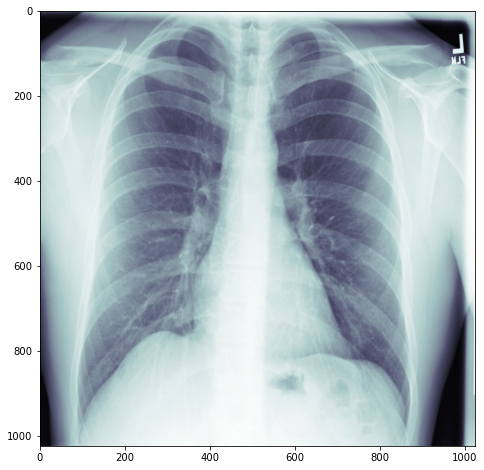

In [8]:
# biore pierwsze zdjęcie z folderu train_fns
data = pydicom.dcmread(train_fns[0])
show_info(data)
plot_pixels(data)

#### Tworzę ramke z danymi na temat pacjenta

In [6]:
missing = 0
multiple = 0
patients_data = []
for k,paths in enumerate(train_fns):
    patient = {}
    img_id = paths.split('\\')[-1]
    data = pydicom.dcmread(paths)
    try:
        tmp = df[df['ImageId'] == '.'.join(img_id.split('.')[:-1])]
        
        if tmp.shape[0] > 1: 
            multiple += 1
        rle = tmp[' EncodedPixels'].values
        if rle[0] == '-1':
            pixels = rle[0]
        else:    
            pixels = [i for i in rle]
        
        patient["UID"] = data.SOPInstanceUID
        patient['EncodedPixels'] = pixels
        patient["Age"] = data.PatientAge
        patient["Sex"] = data.PatientSex
        patient["Modality"] = data.Modality
        patient["BodyPart"] = data.BodyPartExamined
        patient["ViewPosition"] = data.ViewPosition
        patient["filepath"] = paths
        patients_data.append(patient)
    except:
        missing += 1

 

#### Czy w naszej csv mamy wszystkie odpowiedniki do zdjęć z folderu? Czy mamy zdjęcia z więcej niż jedną adnotacją?

In [12]:
print(f'Mamy w folderze {missing} dicomy, których nie ma w naszej csv.')
print(f'Mamy {multiple} zdjęć z więcej niż jedną adnotacją.')
  

Mamy w folderze 42 dicomy, których nie ma w naszej csv.
Mamy 624 zdjęć z więcej niż jedną adnotacją.


#### Jak będzie wyglądała tabela z informacjami na temat pacjenta?

In [11]:
df_patients = pd.DataFrame(patients_data, columns=["UID", "EncodedPixels", "Age", 
                            "Sex", "Modality", "BodyPart", "ViewPosition", "filepath"])

df_patients['Pneumothorax'] = df_patients['EncodedPixels'].apply(lambda x:0 if x == '-1' else 1)
df_patients['Pneumothorax'] = df_patients['Pneumothorax'].astype('int')
df_patients.head() 

,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,filepath,Pneumothorax
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38,M,CR,CHEST,PA,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10,F,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50,F,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68,F,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65,M,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0


#### Jaka jest różnica między liczebnością chorych i zdrowych pacjentów w naszej ramce?

In [10]:
df_patients['Pneumothorax'].value_counts()

0    9378
1    2669
Name: Pneumothorax, dtype: int64

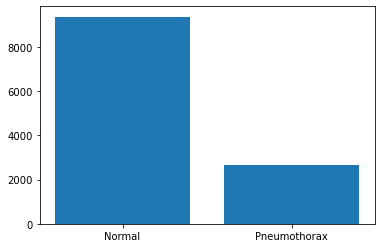

In [20]:
b = df_patients['Pneumothorax'].value_counts()

b1 = ("Normal", "Pneumothorax")
b2 = list(b)

plt.bar(b1, b2)
plt.show()

#### Jak rozkłada się liczba kobiet i mężczyzn w naszych danych?

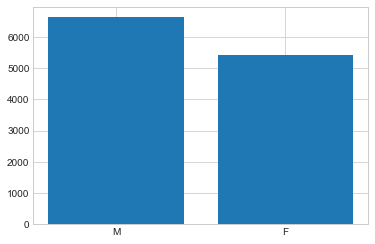

In [45]:
import matplotlib.pyplot as plt
 

a = df_patients.Sex.value_counts()

x = list(a.index)
y = list(a)

plt.bar(x, y)
plt.show()

#### Jaka jest liczebność pozycji AP i PA? Czym one się różnią?

AP - zdjęcie rentgenowskie, na którym wiązki przechodzą od przodu do tyłu. <br />
PA - zdjęcie rentgenowskie, w którym promienie przechodzą przez ciało od tyłu do przodu.<br />
PA to standardowa projekcja, jednak nie zawsze jest możliwa. Zarówno widoki PA, jak i AP są oglądane tak, jakby patrzyły na pacjenta z przodu. Widoki PA są wyższej jakości.

In [21]:
df_patients['ViewPosition'].value_counts()

PA    7274
AP    4773
Name: ViewPosition, dtype: int64

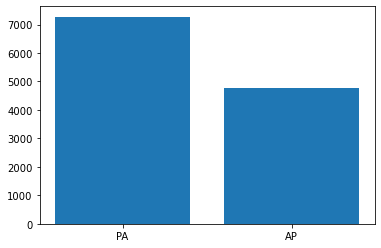

In [25]:
a = df_patients['ViewPosition'].value_counts()

x = list(a.index)
y = list(a)

plt.bar(x, y)
plt.show()



#### Jak rozkłada się wiek pacjentów?

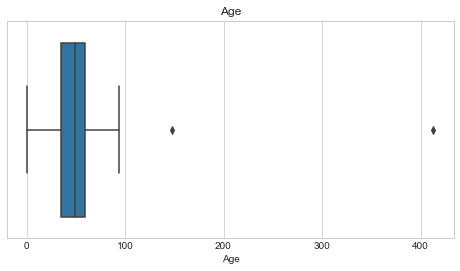

In [14]:
df_patients['Age'] = df_patients['Age'].astype('int') 
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,4))
sns.boxplot(df_patients['Age'])
axes.title.set_text(f'Age')
plt.show()


In [15]:
df_patients[df_patients['Age'] > 100]

,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,filepath,Pneumothorax
1204,1.2.276.0.7230010.3.1.4.8323329.11106.15178752...,-1,413,F,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
9624,1.2.276.0.7230010.3.1.4.8323329.4830.151787518...,-1,148,M,CR,CHEST,PA,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0


Zauważamy, że 2 osoby mają wiek odpowiednio 148 i 413. Wiemy, że jest to niemożliwe dlatego możemy usunąć te rekordy - są one outlierami.

In [ ]:
df_patients = df_patients.drop(df_patients[df_patients['Age'] > 100].index)
print(df_patients.shape)

### Rle - kodowanie

Run-Length Encoding (RLE, kodowanie długości serii) – prosta metoda bezstratnej kompresji danych, której działanie polega na opisywaniu ciągów tych samych liter (bitów, bajtów, symboli, pikseli itp.) za pomocą licznika powtórzeń (długości serii). <br />Przykładowo ciąg:<br />
wwwwwiiiikkkkkkkiiippppppeeeeeddddiia<br />
zapisujemy:<br />
5w4i7k3i6p5e4d2i1a<br />

In [19]:
def rle2mask(rles, width, height):
    
    mask= np.zeros(width* height)
    for rle in rles:
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[0::2]
        lengths = array[1::2]

        current_position = 0
        for index, start in enumerate(starts):
            current_position += start
            mask[current_position:current_position+lengths[index]] = 255
            current_position += lengths[index]

    return mask.reshape(width, height).T

In [16]:
def rle2mask(rle, height, width):
    rle        = [int(xx) for xx in rle.split(' ')]
    offsets, runs = rle[0::2], rle[1::2]
    
    tmp = np.zeros(height * width, dtype=np.uint8)
    for offset, run in zip(offsets, runs):
        tmp[offset:offset + run] = 1
    
    return tmp.reshape(width, height).T

#### Jak będą wyglądały nasze zdjęcia z nałożonymi maskami?

In [20]:
def bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    return rmin, cmin, rmax, cmax #ymin,xmin,ymax,cmax


def plot_imgs(n,df):
    for i in range(n):
        idx = np.random.randint(0,df.shape[0])
        tmp = df.iloc[idx]
        path = tmp['filepath']
        encoding = tmp['EncodedPixels']
        image = pydicom.dcmread(path).pixel_array
        fig, axes = plt.subplots(1,4, figsize=(20,15))
        axes[0].imshow(image, cmap='bone')
        axes[0].set_title('Image')
        mask = rle2mask(encoding,image.shape[0],image.shape[1])
        axes[1].imshow(mask,cmap='gray')
        axes[1].set_title('Mask')
        axes[2].imshow(image,cmap='bone')
        axes[2].imshow(mask,alpha=0.3,cmap='Reds')
        axes[2].set_title('Image + mask')
        rmin, cmin, rmax, cmax = bounding_box(mask)
        image_rgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        cv2.rectangle(image_rgb, (cmin,rmin),(cmax,rmax), (255,255,0), 5)
        axes[3].imshow(image_rgb)
        axes[3].imshow(mask,alpha=0.3,cmap='Reds')
        axes[3].set_title('Image Box Annoted')
        plt.show()

#### Przykładowe wywołąnie dla 10 zdjęć

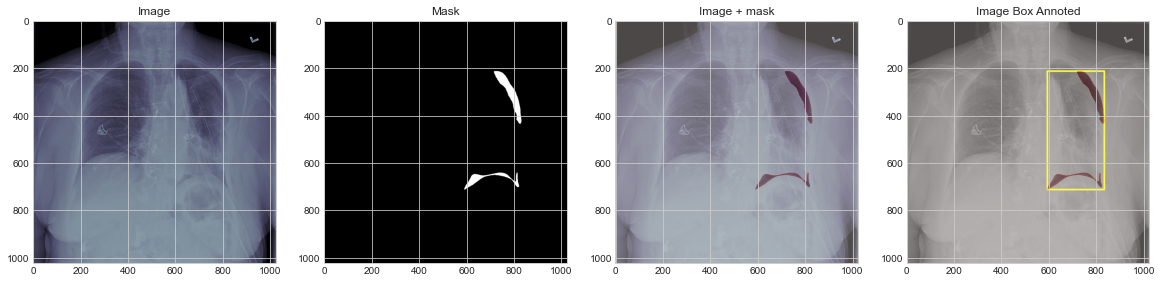

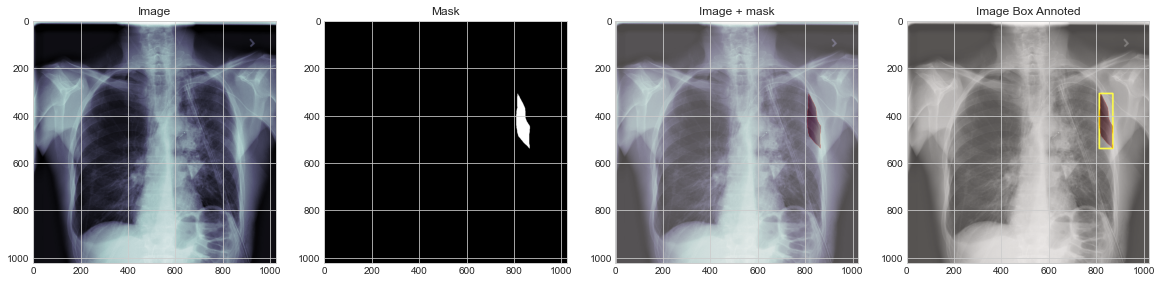

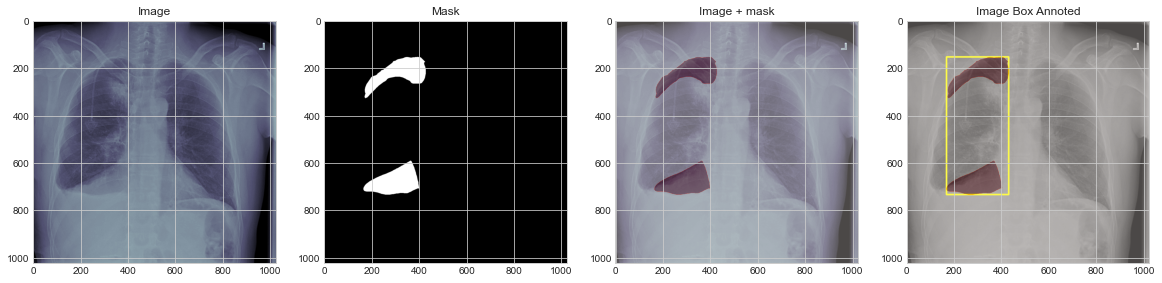

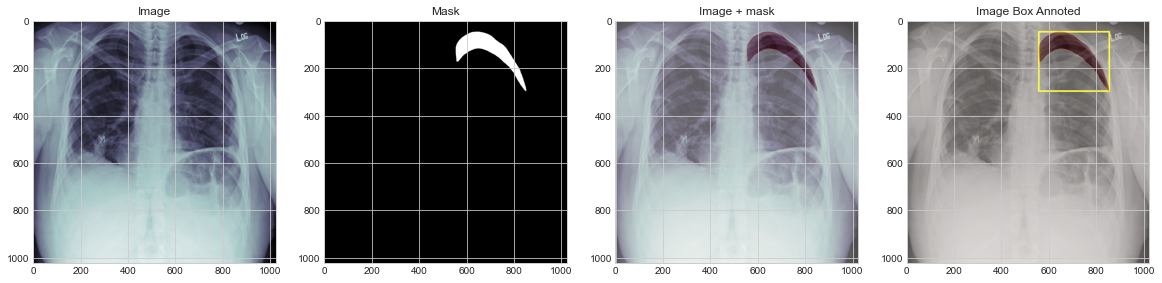

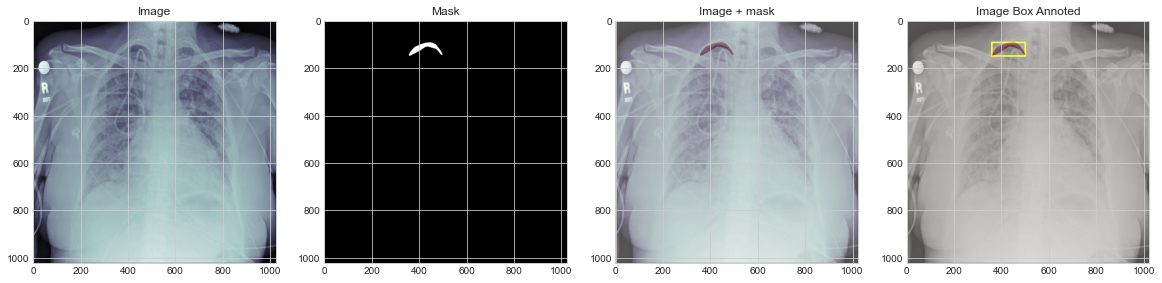

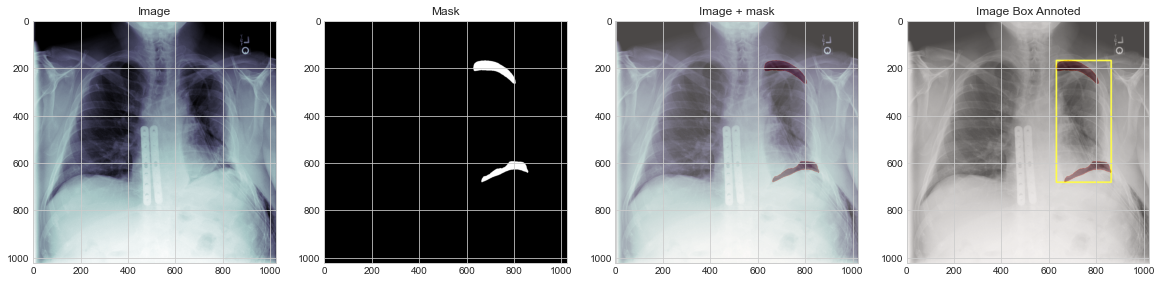

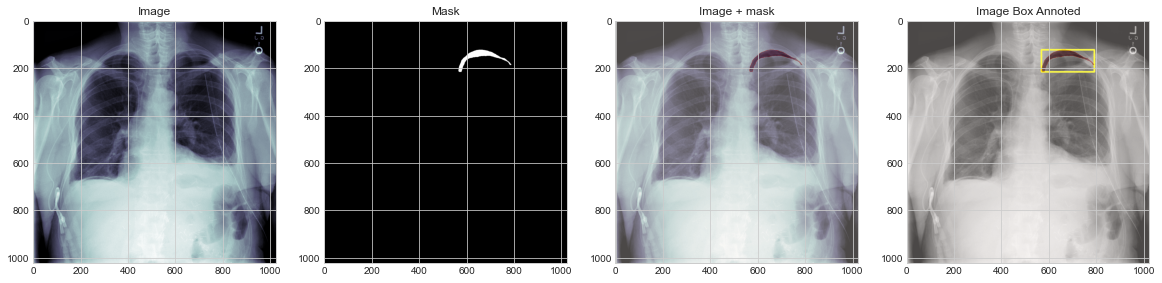

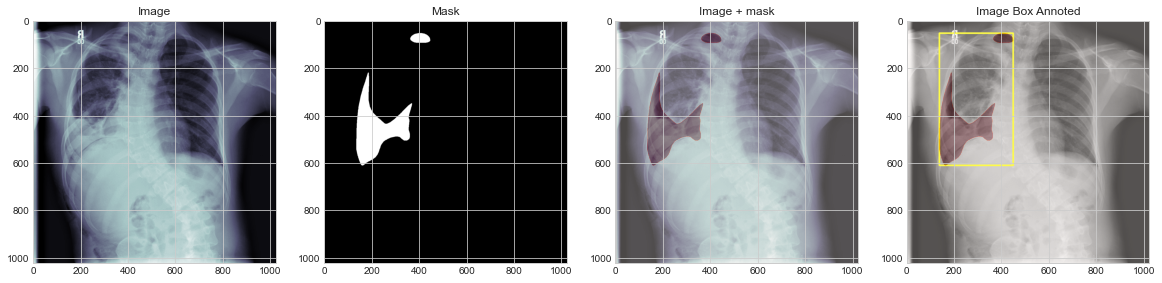

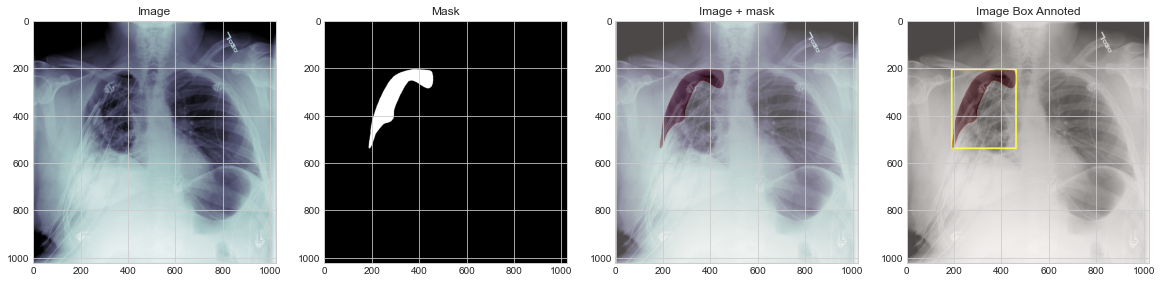

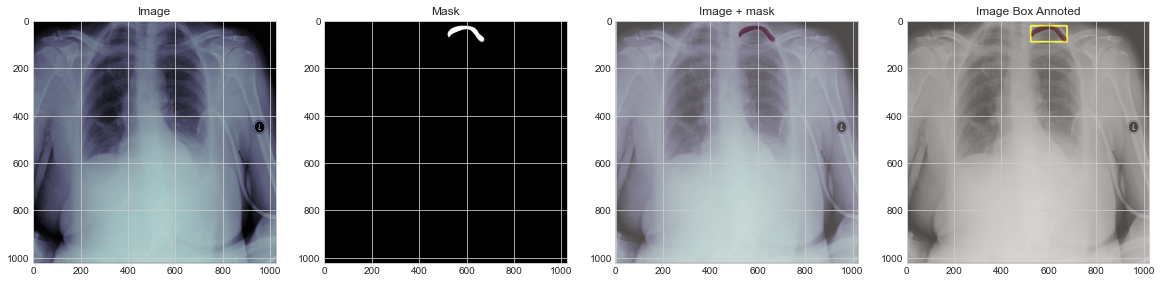

In [22]:
tmp = df_patients[df_patients['Pneumothorax'] == 1].reset_index(drop=True)
plot_imgs(10,tmp)

W raporcie korzystałam z przydatnych kodów ze stron:
- https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
- https://www.kaggle.com/retyidoro/eda-of-pneumothorax-dataset

## WNIOSKI

W danych warto zwrócić uwagę na to, że w ramce train-rle jest 12047 unikalnych zdjęć z 12954 wierszy. Ponadto widzimy, że w folderze train znacząco przeważają osoby zdrowe nad osobami chorymi. Przy analizie wieku pacjentów zauważyliśmy, że mamy 2 nieprawidłowości. Pacjentów w wieku 148 i 413. Wiemy, że jest to niemożliwe, więc w naszym modelu nie powinniśmy ich brać pod uwagę. 